In [1]:
import requests
import gzip
import shutil
import shlex
import subprocess as sp
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

import numpy as np

sys.path.insert(0, '../src')
from util import plot_pca, plot_eigenval

from bioinfokit import analys, visuz

## Get data


In [ ]:
cfg = load_params("../config/data-params.json")
for file_id, filename in cfg['files']:
    destination = '../data/'+filename
    download_file_from_google_drive(file_id, destination)
    uncompress(destination)

## EDA

### SNPs

In [ ]:
df = pd.read_table('../data/crytic.map', header=None)
d

In [ ]:
df[0].value_counts().sort_index().plot(kind = 'bar')

### ped file

In [15]:
df = pd.read_table('../data/crytic.ped', header=None)
df[0] = df[0].apply(lambda x: x.split(' ')[:6])
for i in range(1,7):
    df[str(i)] = df[0].apply(lambda x:x[i-1])
df = df.drop(0, axis=1)
df.columns = ['Effect', 'IID', 'Father', 'Mother', 'Sex', 'Phenotype']
df

,Effect,IID,Father,Mother,Sex,Phenotype
0,WGAAD,10,0,0,2,2
1,WGAAD,15,0,0,1,2
2,WGAAD,18,0,0,1,2
3,WGAAD,20,0,0,1,2
4,WGAAD,24,0,0,2,2
5,WGAAD,25,0,0,2,2
6,WGAAD,28,0,0,2,2
7,WGAAD,29,0,0,1,2
8,WGAAD,31,0,0,1,2
9,WGAAD,35,0,0,2,2


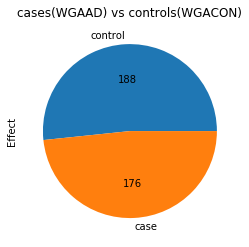

In [18]:
df['Effect'].replace({'WGAAD':'case', 'WGACON':'control'}).value_counts().plot(kind='pie', title = 'cases(WGAAD) vs controls(WGACON)', autopct=lambda x:int(x*364/100))

In [ ]:
df['FID'].value_counts()

In [ ]:
df['Sex'].value_counts()

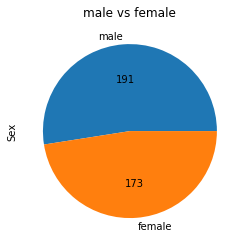

In [20]:
df['Sex'].replace({'1': 'male', '2':'female'}).value_counts().plot(kind='pie', title = 'male vs female', autopct=lambda x:int(x*364/100)+1)

In [ ]:
df[['Father', 'Mother']].astype(int).sum()

### PCA

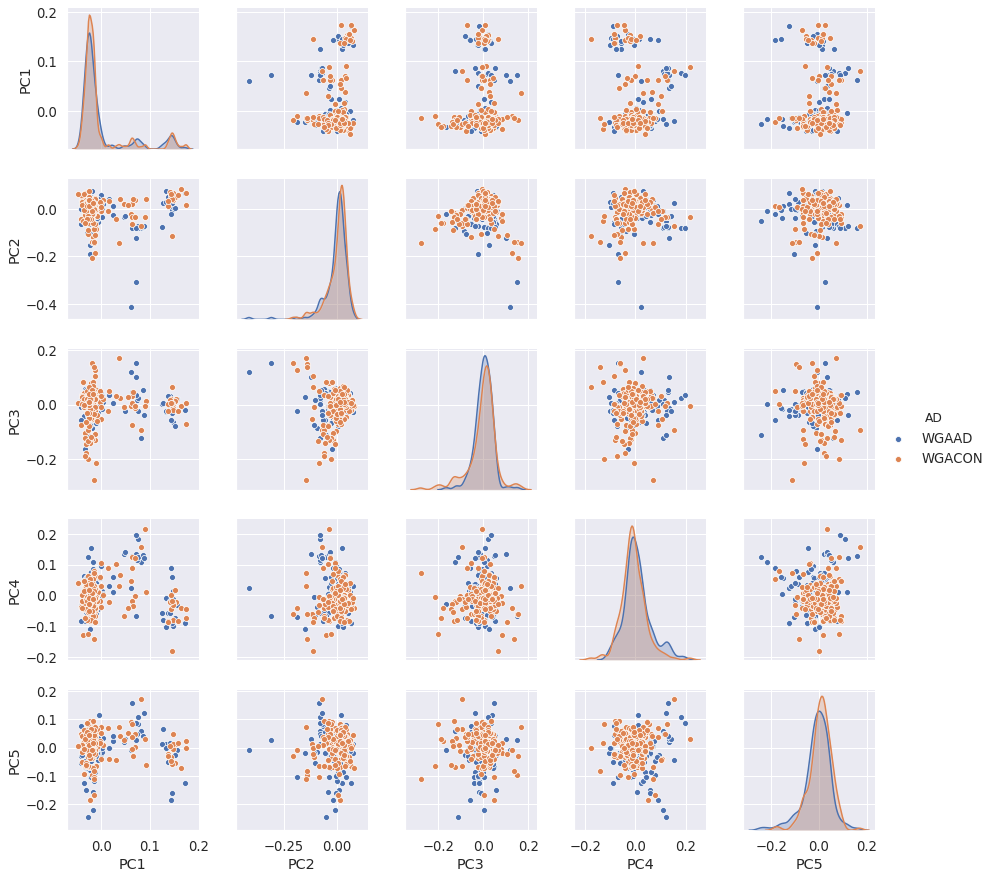

In [2]:
plot_pca('../data/pca.eigenvec')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


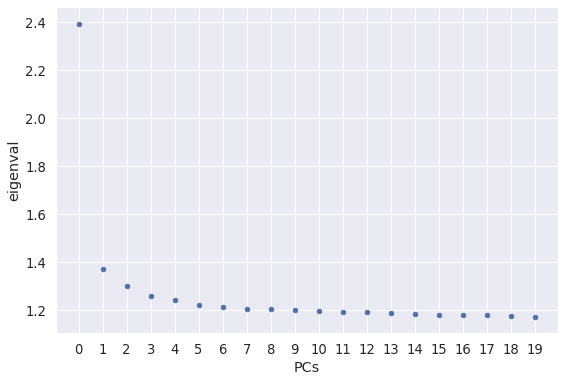

In [4]:
plot_eigenval('../data/pca.eigenval')

In [14]:
def plot_pca(filename):
    df = pd.read_table(filename ,header = None,sep=' ')
    df = df[[0,2,3,4,5,6]]
    df.columns = ['AD','PC1','PC2','PC3','PC4','PC5']
    sns.set(font_scale=1.3)
    sns.pairplot(df, hue='AD', vars=['PC1','PC2','PC3','PC4','PC5'])


### Logistic

In [ ]:
def regional_manhattan(df, gene, chromo, start, end, gap=500000):
    
    def set_color(pos, start, end, gene):
        if pos<start:
            return 'AALeft'
        elif pos>end:
            return 'ZRight'
        return gene
    temp=df[(df['BP'].astype(int)>(int(start)-gap)) & (df['BP'].astype(int)<(int(end)+gap)) & (df['CHR']==chromo)]
    
    temp['color'] = temp['BP'].apply(lambda x: set_color(x, start, end, gene))
    visuz.marker.mhat(df=temp, chr='color',pv='P', show=True, gwas_sign_line=True, dim=(15,10), axxlabel='{} (Chromosome {})'.format(gene, str(chromo)), dotsize=10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Text(0.5, 0, 'Based Pairs')

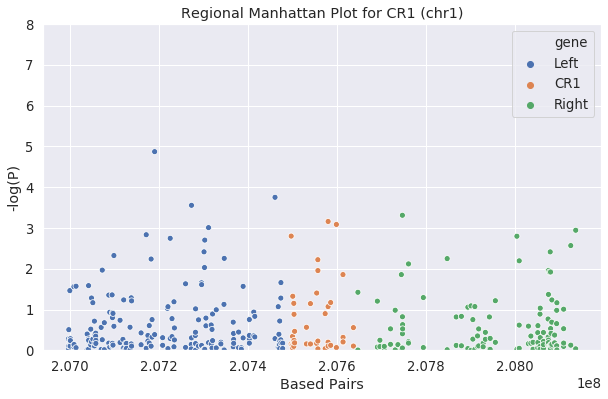

In [8]:
gene, chromo, start, end, gap=genes.iloc[0]['gene'], genes.iloc[0]['chr'], genes.iloc[0]['start'], genes.iloc[0]['end'], 500000

def set_color(pos, start, end, gene):
        if pos<start:
            return 'Left'
        elif pos>end:
            return 'Right'
        return gene
temp=df[(df['BP'].astype(int)>(int(start)-gap)) & (df['BP'].astype(int)<(int(end)+gap)) & (df['CHR']==chromo)]

temp['gene'] = temp['BP'].apply(lambda x: set_color(x, start, end, gene))

temp['-log(P)'] = -np.log10(temp['P'])

plt.figure(figsize=(10,6))
sns.scatterplot(data=temp, x='BP', y='-log(P)', hue = 'gene').set(ylim=(0, 8))
sns.lineplot()
plt.title('Regional Manhattan Plot for {} (chr{})'.format(gene, chromo))
plt.xlabel('Based Pairs')

In [21]:
df = pd.read_table('../data/pca1.assoc.logistic', delim_whitespace=True)
df

,CHR,SNP,BP,A1,TEST,NMISS,OR,SE,L95,U95,STAT,P
0,1,rs3094315,792429,C,ADD,361,1.3090,0.2065,0.873500,1.963,1.305000,0.19180
1,1,rs3094315,792429,C,COV1,361,0.8709,2.0260,0.016430,46.170,-0.068220,0.94560
2,1,rs2980300,825852,A,ADD,342,1.2650,0.2158,0.829000,1.931,1.091000,0.27540
3,1,rs2980300,825852,A,COV1,342,0.8403,2.0490,0.015160,46.590,-0.084920,0.93230
4,1,rs4075116,1043552,G,ADD,363,1.0350,0.1600,0.756600,1.417,0.216900,0.82830
5,1,rs4075116,1043552,G,COV1,363,1.4320,2.0070,0.028010,73.210,0.178900,0.85800
6,1,rs9442385,1137258,T,ADD,362,0.7017,0.2723,0.411500,1.197,-1.301000,0.19330
7,1,rs9442385,1137258,T,COV1,362,1.7450,2.0090,0.034030,89.490,0.277200,0.78160
8,1,rs10907175,1170650,C,ADD,353,1.1940,0.2785,0.691700,2.061,0.636500,0.52440
9,1,rs10907175,1170650,C,COV1,353,1.0820,2.0610,0.019060,61.440,0.038360,0.96940


In [2]:
genes = pd.read_csv('../data/9gene.csv')
genes

,gene,start,end,chr
0,CR1,207496152,207641765,1
1,BIN1,127048023,127107154,2
2,CLU,27596917,27615031,8
3,PICALM,85957175,86069860,11
4,MS4A4/MS4A46E,60185702,60317944,11
5,CD2AP,47477746,47627263,6
6,CD33,51215537,51243860,19
7,EPHA1,143390289,143408892,7
8,ABCA7,1040107,1065572,19


In [13]:
genes = pd.read_csv('../data/9gene.csv')
for i, row in genes.iterrows():
    temp=df[(df['BP'].astype(int)>int(row['start'])) & (df['BP'].astype(int)<int(row['end'])) & (df['CHR']==row['chr'])]
    print(row['gene'])
    print(len(temp[temp['P']<0.05]))
    if len(temp[temp['P']<0.05])>0:
        print(temp[temp['P']<0.05][['SNP', 'P']])

CR1
2
             SNP        P
45554  rs7514606  0.04243
45558  rs6540648  0.04565
BIN1
0
CLU
0
PICALM
3
               SNP        P
471814   rs7935611  0.04535
471854  rs10898524  0.04447
471860   rs1938936  0.04430
MS4A4/MS4A46E
0
CD2AP
0
CD33
0
EPHA1
0
ABCA7
0


In [9]:
np.log10(0.05)

-1.3010299956639813

In [ ]:
temp=df[(df['BP']>(row['start']-50000000)) & (df['BP']<(row['end']+50000000)) & (df['CHR']==1)]
temp

In [ ]:
visuz.marker.mhat(df=df, chr='CHR',pv='P', show=True, gwas_sign_line=True, dim=(15,10))

In [ ]:
df.sort_values('P')

In [ ]:
df.sort_values('P')

In [3]:
df = pd.read_table('../data/pca_test.assoc.logistic', delim_whitespace=True)
df

,CHR,SNP,BP,A1,TEST,NMISS,OR,SE,L95,U95,STAT,P
0,1,rs3094315,792429,C,ADD,361,1.3110,0.2052,0.877200,1.9610,1.321000,0.18640
1,1,rs3094315,792429,C,COV3,361,8.5930,2.0370,0.158600,465.5000,1.056000,0.29090
2,1,rs2980300,825852,A,ADD,342,1.2580,0.2164,0.823300,1.9230,1.061000,0.28860
3,1,rs2980300,825852,A,COV3,342,13.5700,2.0840,0.228200,806.5000,1.251000,0.21090
4,1,rs4075116,1043552,G,ADD,363,1.0390,0.1597,0.759600,1.4210,0.238700,0.81140
5,1,rs4075116,1043552,G,COV3,363,6.3070,2.0410,0.115600,344.1000,0.902500,0.36680
6,1,rs9442385,1137258,T,ADD,362,0.6962,0.2724,0.408200,1.1870,-1.329000,0.18380
7,1,rs9442385,1137258,T,COV3,362,7.6320,2.0330,0.141900,410.4000,0.999600,0.31750
8,1,rs10907175,1170650,C,ADD,353,1.1770,0.2758,0.685600,2.0210,0.591300,0.55430
9,1,rs10907175,1170650,C,COV3,353,12.8500,2.0900,0.213800,772.9000,1.222000,0.22180


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


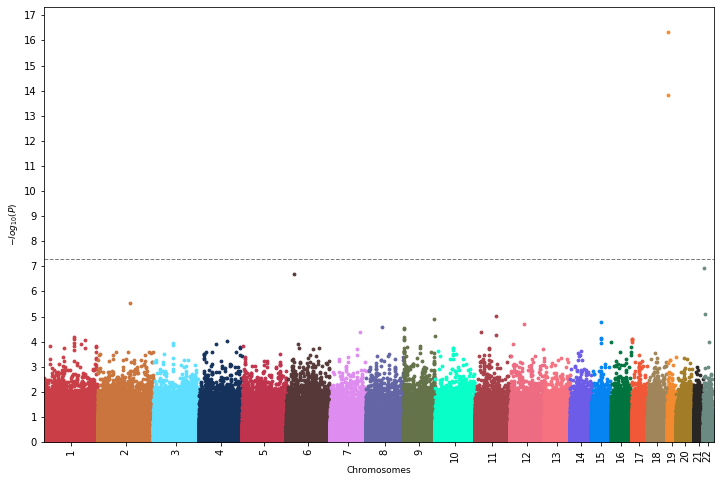

In [4]:
visuz.marker.mhat(df=df, chr='CHR',pv='P', show=True, gwas_sign_line=True, dim=(12,8))

In [17]:
y = -np.log(df['P']).sort_values().dropna()
y

658132    37.872502
658134    32.322730
694702    16.002983
276384    15.261130
68958     12.802093
            ...    
80481     -0.000000
587933    -0.000000
214351    -0.000000
31567     -0.000000
265919    -0.000000
Name: P, Length: 697796, dtype: float64

In [18]:
len(y)

697796

In [27]:
X = -np.log(np.arange(1/len(y), 1, (1-1/len(y))/(len(y))))

In [25]:
def qqplot(data):
    y = -np.log10(data).sort_values().dropna()
    X = -np.log10(np.arange(1/len(y), 1, (1-1/len(y))/(len(y))))
    sns.set()
    sns.scatterplot(X, y, linewidth=0)
    plt.xlabel('-log(expected p-values)')
    plt.ylabel('-log(observed p-values)')
    sns.lineplot(x=-np.log10([1/len(y), 1]), y=-np.log10([1/len(y), 1]), color='red')

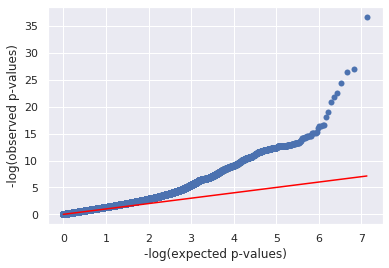

In [28]:
qqplot(df['P-value'])

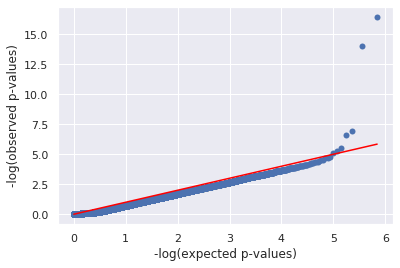

In [26]:
qqplot(df['P'])

In [27]:
df = pd.read_table('../../generic-metal/METAANALYSIS1.TBL')
df

,MarkerName,Allele1,Allele2,Weight,Zscore,P-value,Direction
0,rs2326918,a,g,2.0,0.856,0.391800,++?
1,rs112634005,a,c,1.0,1.440,0.149900,+??
2,rs7929618,c,g,1.0,0.951,0.341600,?+?
3,rs151222586,a,g,1.0,1.250,0.211200,+??
4,rs561059020,t,c,1.0,2.093,0.036320,+??
5,rs6039163,t,c,1.0,1.986,0.047060,+??
6,rs66941928,t,c,2.0,1.516,0.129600,++?
7,rs146253013,t,c,1.0,0.348,0.727800,+??
8,rs7190157,a,c,2.0,1.914,0.055600,++?
9,rs12364336,a,g,2.0,0.835,0.403500,++?


In [29]:
check = ['rs429358', 'rs4420638', 'rs867198', 'rs3011823', 'rs9309095', 'rs4821510', 'rs1155331', 'rs11114028', 'rs7043927', 'rs1393404']

In [33]:
df[df['MarkerName'].apply(lambda x: x in check)].drop(columns=['Weight', 'Direction', 'Zscore'])

,MarkerName,Allele1,Allele2,P-value
226568,rs1393404,a,g,0.627500
615727,rs1155331,t,c,0.077790
2013534,rs4420638,a,g,0.000680
3242755,rs7043927,a,g,0.467900
9105518,rs429358,t,c,0.000221
10550533,rs9309095,t,c,0.316000
11268026,rs4821510,t,c,0.085530
11511496,rs11114028,a,g,0.017180
11844708,rs867198,t,c,0.103600


In [2]:
df = pd.read_table('../data/pca1.assoc.logistic', delim_whitespace=True)
df

,CHR,SNP,BP,A1,TEST,NMISS,OR,SE,L95,U95,STAT,P
0,1,rs3094315,792429,C,ADD,361,1.3090,0.2065,0.873500,1.963,1.305000,0.19180
1,1,rs3094315,792429,C,COV1,361,0.8709,2.0260,0.016430,46.170,-0.068220,0.94560
2,1,rs2980300,825852,A,ADD,342,1.2650,0.2158,0.829000,1.931,1.091000,0.27540
3,1,rs2980300,825852,A,COV1,342,0.8403,2.0490,0.015160,46.590,-0.084920,0.93230
4,1,rs4075116,1043552,G,ADD,363,1.0350,0.1600,0.756600,1.417,0.216900,0.82830
5,1,rs4075116,1043552,G,COV1,363,1.4320,2.0070,0.028010,73.210,0.178900,0.85800
6,1,rs9442385,1137258,T,ADD,362,0.7017,0.2723,0.411500,1.197,-1.301000,0.19330
7,1,rs9442385,1137258,T,COV1,362,1.7450,2.0090,0.034030,89.490,0.277200,0.78160
8,1,rs10907175,1170650,C,ADD,353,1.1940,0.2785,0.691700,2.061,0.636500,0.52440
9,1,rs10907175,1170650,C,COV1,353,1.0820,2.0610,0.019060,61.440,0.038360,0.96940


In [3]:
genes = pd.read_csv('../data/9gene.csv')
genes

,gene,start,end,chr
0,CR1,207496152,207641765,1
1,BIN1,127048023,127107154,2
2,CLU,27596917,27615031,8
3,PICALM,85957175,86069860,11
4,MS4A4/MS4A46E,60185702,60317944,11
5,CD2AP,47477746,47627263,6
6,CD33,51215537,51243860,19
7,EPHA1,143390289,143408892,7
8,ABCA7,1040107,1065572,19


In [9]:
temp=df[(df['BP'].astype(int)>(int(207496152)-5000000)) & (df['BP'].astype(int)<(int(207641765)+5000000)) & (df['CHR']==1)]

In [11]:
temp.sort_values('P')

,CHR,SNP,BP,A1,TEST,NMISS,OR,SE,L95,U95,STAT,P
44058,1,rs7364618,202589311,T,ADD,361,0.3924,0.2828,0.22540,0.6830,-3.308000,0.000938
44898,1,rs10494914,205585534,C,ADD,352,3.7350,0.3999,1.70600,8.1790,3.296000,0.000982
45734,1,rs701911,208293979,T,ADD,363,1.7160,0.1660,1.23900,2.3750,3.251000,0.001148
44610,1,rs1249868,204758560,T,ADD,352,1.6690,0.1790,1.17500,2.3710,2.862000,0.004215
46150,1,rs17020949,210105887,A,ADD,337,0.1641,0.6339,0.04738,0.5685,-2.851000,0.004358
44664,1,rs727524,204895054,A,ADD,342,0.1162,0.7583,0.02628,0.5135,-2.839000,0.004524
44712,1,rs12047825,204994202,A,ADD,343,0.3195,0.4034,0.14490,0.7043,-2.829000,0.004667
45740,1,rs6540709,208378937,C,ADD,345,0.6403,0.1586,0.46930,0.8737,-2.812000,0.004931
44040,1,rs1891092,202517142,T,ADD,364,0.4906,0.2540,0.29820,0.8072,-2.803000,0.005058
45742,1,rs7534335,208396840,C,ADD,363,0.6510,0.1568,0.47870,0.8853,-2.737000,0.006197
